<a href="https://colab.research.google.com/github/galua2001/colab/blob/main/trash1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!pip install -q -U google-generativeai

import google.generativeai as genai
from google.colab import userdata

# 코랩에 저장된 API 키를 불러옵니다.
API_KEY = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=API_KEY)

# 사용할 모델 설정
model = genai.GenerativeModel('gemini-pro')


In [34]:
from google.colab import drive
import os
import glob
from PIL import Image
import numpy as np

# 구글 드라이브 마운트
drive.mount('/content/drive')

# 데이터셋 경로 지정
dataset_base_path = '/content/drive/MyDrive/my_dataset'

# 이미지 파일 경로와 라벨 목록을 담을 리스트
train_images = []
train_labels = []
test_images = []
test_labels = []

# 각 클래스 폴더의 이름을 라벨로 사용
class_names = sorted(os.listdir(os.path.join(dataset_base_path, 'train')))
class_to_idx = {name: i for i, name in enumerate(class_names)}
print(f"클래스 매핑: {class_to_idx}")

# train 데이터 불러오기
for class_name in class_names:
    class_path = os.path.join(dataset_base_path, 'train', class_name)
    for img_path in glob.glob(os.path.join(class_path, '*.jpg')):
        img = Image.open(img_path).convert('RGB') # 이미지 로드 및 RGB 변환
        img = img.resize((28, 28)) # 원하는 크기로 리사이즈
        train_images.append(np.array(img))
        train_labels.append(class_to_idx[class_name])

# test 데이터 불러오기 (위와 동일한 과정)
print("\n--- 테스트 데이터 로딩 디버깅 ---")
for class_name in class_names:
    class_path = os.path.join(dataset_base_path, 'test', class_name)
    print(f"확인 중인 테스트 경로: {class_path}")
    test_files_in_class = glob.glob(os.path.join(class_path, '*.jpg'))
    print(f"찾은 파일: {test_files_in_class}")
    for img_path in test_files_in_class:
        img = Image.open(img_path).convert('RGB')
        img = img.resize((28, 28))
        test_images.append(np.array(img))
        test_labels.append(class_to_idx[class_name])
print("--- 테스트 데이터 로딩 디버깅 완료 ---\n")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
클래스 매핑: {'class_0': 0, 'class_1': 1, 'class_2': 2, 'class_3': 3, 'class_4': 4}

--- 테스트 데이터 로딩 디버깅 ---
확인 중인 테스트 경로: /content/drive/MyDrive/my_dataset/test/class_0
찾은 파일: []
확인 중인 테스트 경로: /content/drive/MyDrive/my_dataset/test/class_1
찾은 파일: []
확인 중인 테스트 경로: /content/drive/MyDrive/my_dataset/test/class_2
찾은 파일: []
확인 중인 테스트 경로: /content/drive/MyDrive/my_dataset/test/class_3
찾은 파일: []
확인 중인 테스트 경로: /content/drive/MyDrive/my_dataset/test/class_4
찾은 파일: []
--- 테스트 데이터 로딩 디버깅 완료 ---



In [35]:
# 리스트를 NumPy 배열로 변환
train_input = np.array(train_images)
train_target = np.array(train_labels).astype(int)
test_input = np.array(test_images)
test_target = np.array(test_labels).astype(int)

# 픽셀 값 정규화 (0-255 -> 0.0-1.0)
train_input = train_input / 255.0
test_input = test_input / 255.0

# 데이터 형태 확인
print(f"훈련 이미지 형태: {train_input.shape}")
print(f"훈련 라벨 형태: {train_target.shape}")
print(f"테스트 이미지 형태: {test_input.shape}")
print(f"테스트 라벨 형태: {test_target.shape}")

# 최종적으로 아래와 같은 형식으로 데이터를 묶습니다.
(train_input, train_target), (test_input, test_target) = (train_input, train_target), (test_input, test_target)

# 이제 keras 모델에 이 데이터를 바로 사용할 수 있습니다.
# model.fit(train_input, train_target, ...)

훈련 이미지 형태: (1332, 28, 28, 3)
훈련 라벨 형태: (1332,)
테스트 이미지 형태: (0,)
테스트 라벨 형태: (0,)


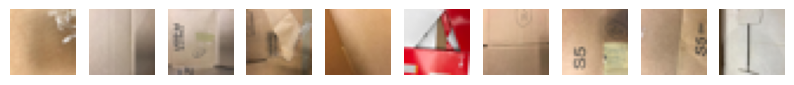

In [36]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 10, figsize=(10,10))
for i in range(10):
    axs[i].imshow(train_input[i], cmap='gray_r')
    axs[i].axis('off')
plt.show()

In [37]:
print([train_target[i] for i in range(10)])

[np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


In [38]:
import numpy as np

print(np.unique(train_target, return_counts=True))

(array([0, 1, 2, 3, 4]), array([258, 258, 258, 258, 300]))


In [39]:
train_scaled = train_input / 255.0
train_scaled = train_scaled.reshape(-1, 28 * 28 * 3) # RGB 이미지를 1차원으로 펼치므로 28*28*3

In [40]:
print(train_scaled.shape)

(1332, 2352)


In [41]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier

sc = SGDClassifier(loss='log_loss', max_iter=5, random_state=42)

scores = cross_validate(sc, train_scaled, train_target, n_jobs=-1)
print(np.mean(scores['test_score']))

0.2229083945819605


In [42]:
import tensorflow as tf

In [43]:
from tensorflow import keras

In [44]:
from sklearn.model_selection import train_test_split

# 훈련 데이터와 검증 데이터로 분할 (1차원으로 펼치기 전에 분할)
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

# 데이터 형태 확인
print(f"분할 후 훈련 이미지 형태: {train_input.shape}")
print(f"분할 후 훈련 라벨 형태: {train_target.shape}")
print(f"분할 후 검증 이미지 형태: {val_input.shape}")
print(f"분할 후 검증 라벨 형태: {val_target.shape}")

분할 후 훈련 이미지 형태: (1065, 28, 28, 3)
분할 후 훈련 라벨 형태: (1065,)
분할 후 검증 이미지 형태: (267, 28, 28, 3)
분할 후 검증 라벨 형태: (267,)


In [45]:
print(train_scaled.shape, train_target.shape)

(1332, 2352) (1065,)


In [46]:

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28, 3)), # 이미지를 1차원으로 펼침 (28*28*3 = 2352)
    keras.layers.Dense(128, activation='relu'), # 은닉층 (활성화 함수: ReLU)
    keras.layers.Dense(5, activation='softmax') # 출력층 (클래스 수: 5, 활성화 함수: Softmax)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [47]:
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [48]:
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [49]:
print(train_target[:10])

[4 2 3 1 0 1 3 0 1 0]


In [50]:
# 모델 훈련 (1차원으로 펼치지 않은 데이터 사용)
history = model.fit(train_input, train_target, epochs=10, validation_data=(val_input, val_target))

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.1766 - loss: 3.8927 - val_accuracy: 0.2247 - val_loss: 2.1368
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2248 - loss: 1.8123 - val_accuracy: 0.2996 - val_loss: 1.5608
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2833 - loss: 1.5891 - val_accuracy: 0.1985 - val_loss: 1.5997
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2918 - loss: 1.5581 - val_accuracy: 0.2135 - val_loss: 1.8107
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3611 - loss: 1.5191 - val_accuracy: 0.3296 - val_loss: 1.5810
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3684 - loss: 1.4937 - val_accuracy: 0.2959 - val_loss: 1.6586
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3888 - loss: 1.4580 - val_accuracy: 0.3708 - val_loss: 1.4766
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4367 - loss: 1.3997 - val_accuracy: 0.2959 - v

In [51]:
model.evaluate(val_input, val_target)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4471 - loss: 1.3505 


[1.3858466148376465, 0.4569288492202759]

'/content/drive/MyDrive/my_dataset/trash' 폴더에서 137개의 이미지 파일을 찾았습니다.


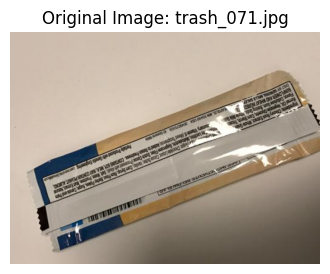

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


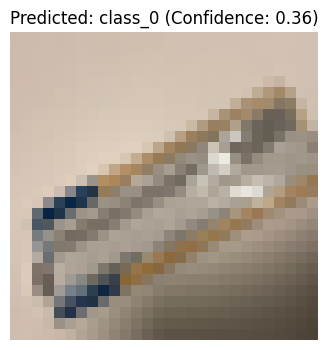

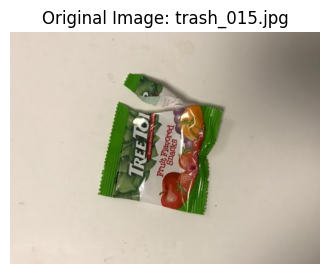

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


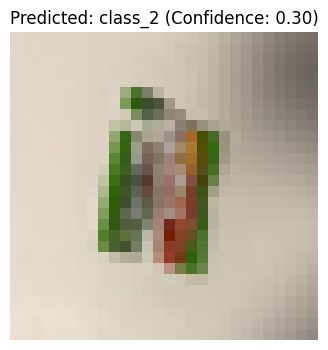

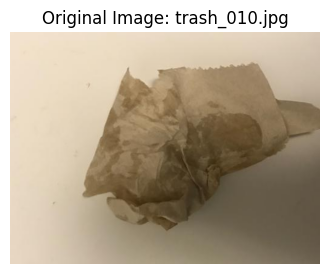

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


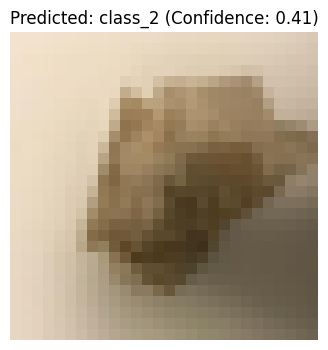

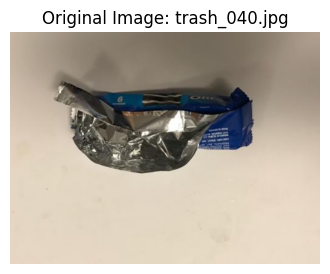

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


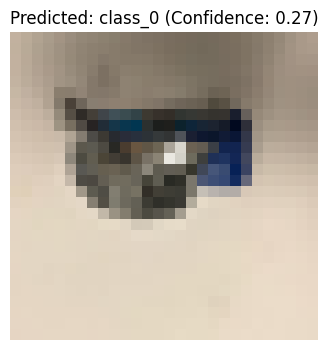

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


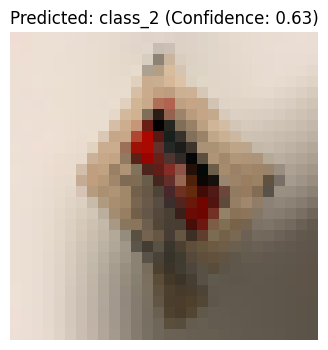

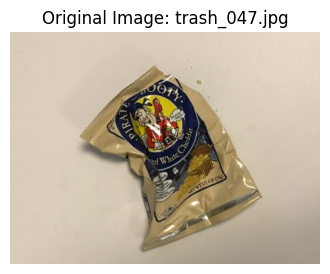

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


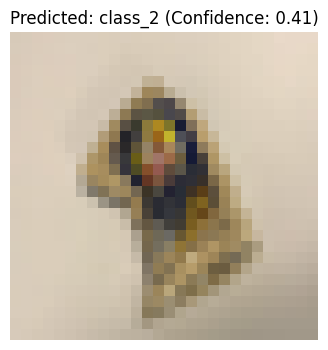

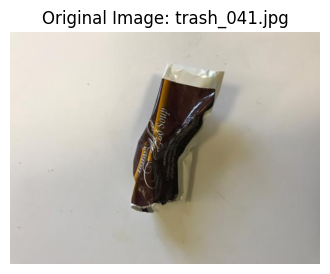

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


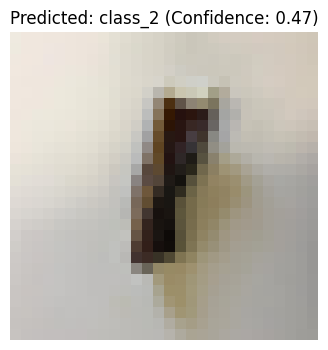

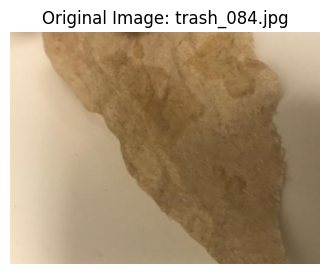

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


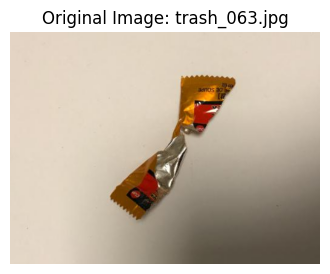

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


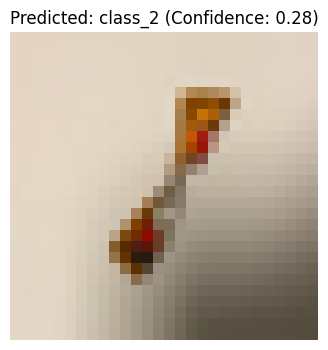

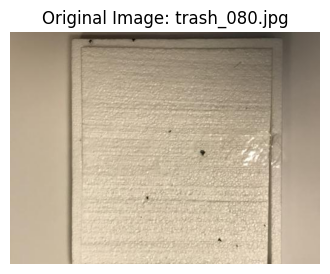

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


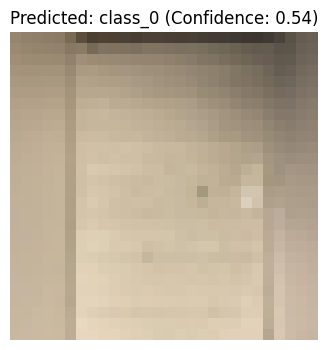

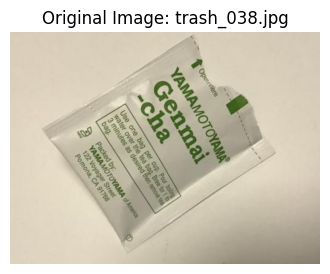

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


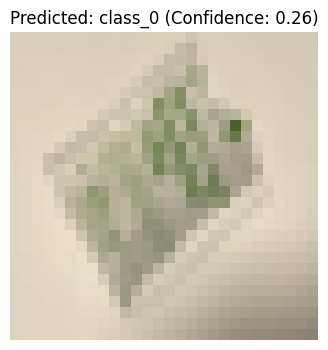

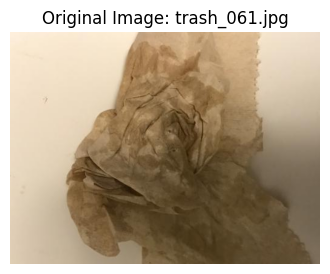

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


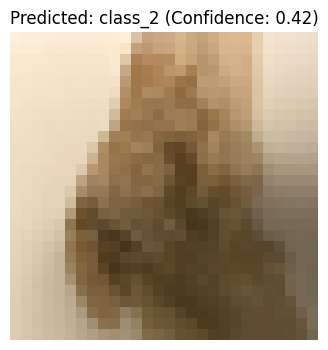

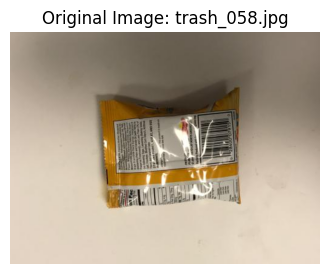

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


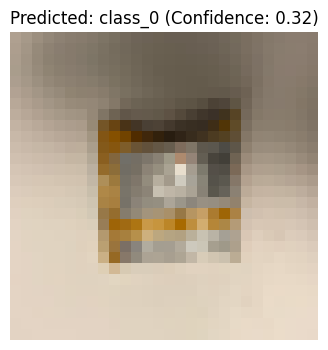

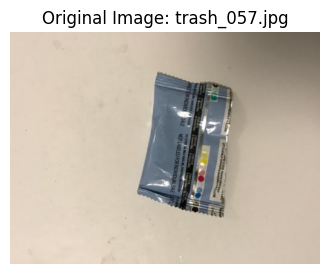

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


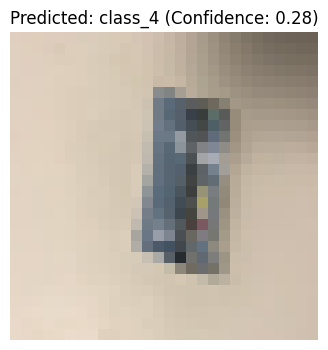

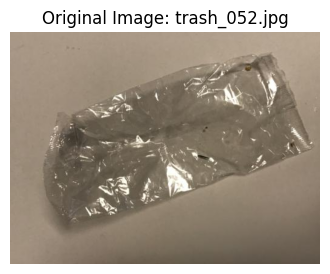

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


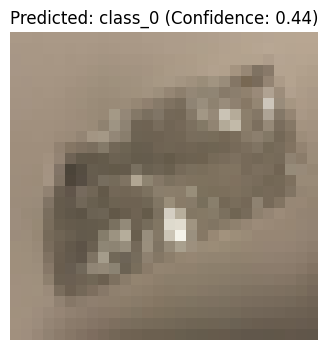

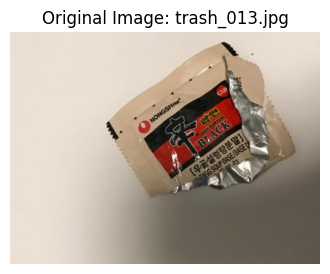

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


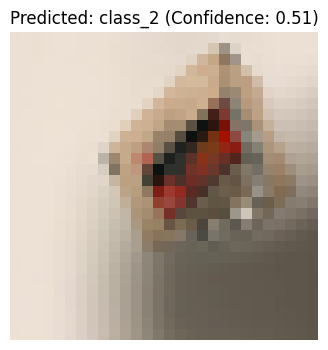

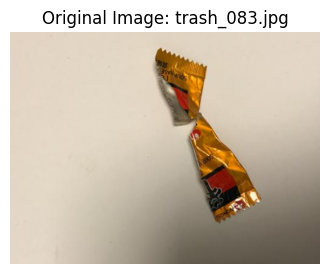

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


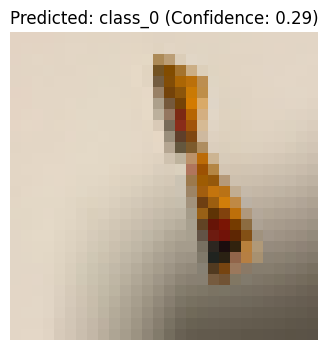

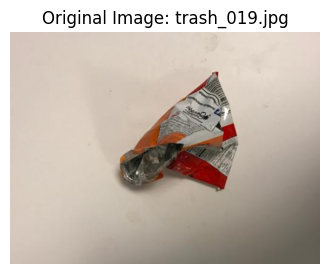

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


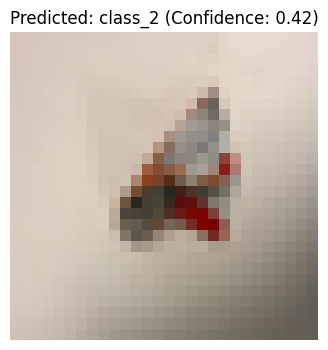

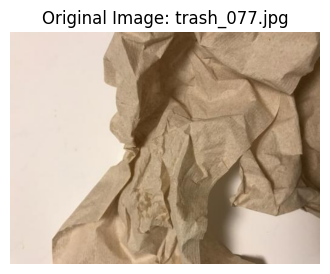

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


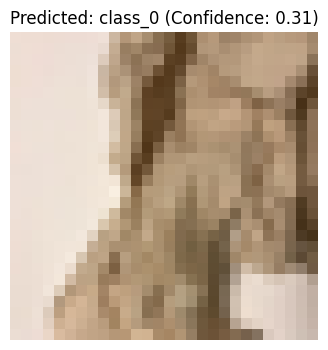

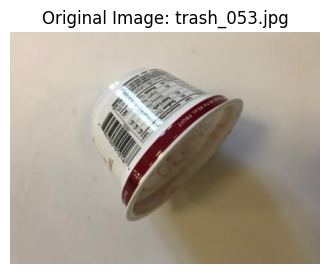

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


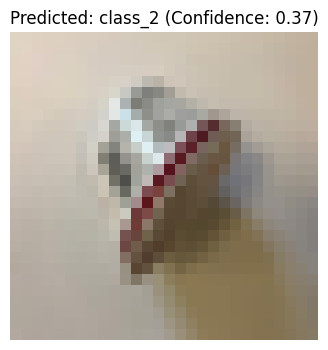

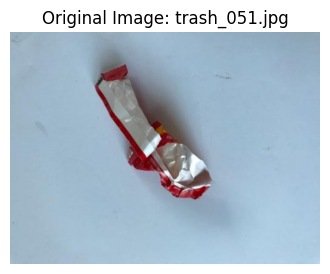

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


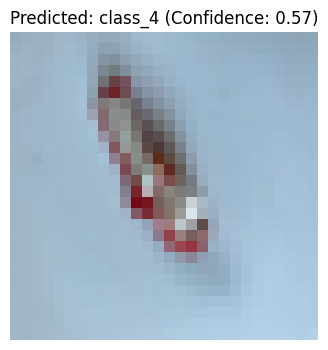

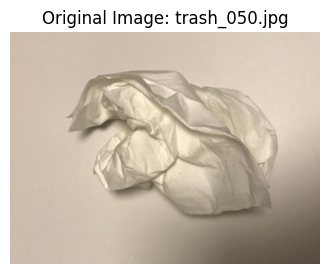

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


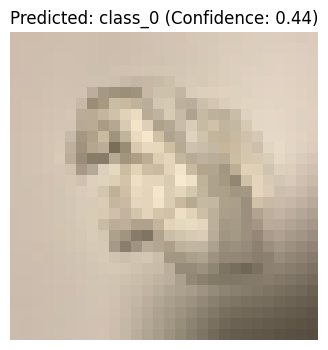

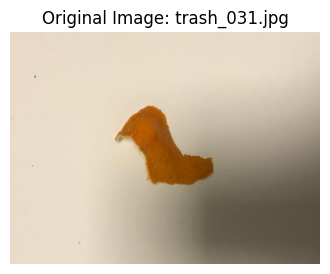

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


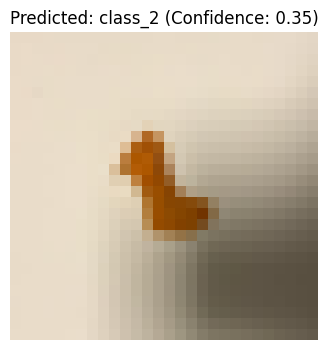

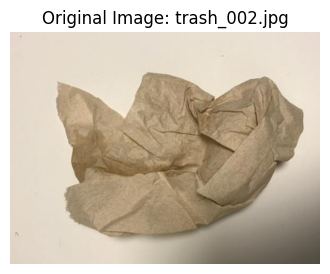

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


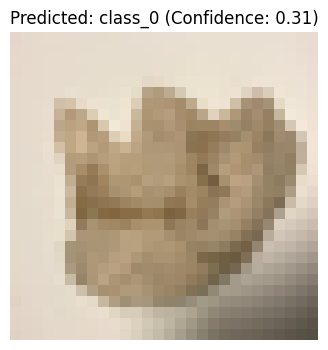

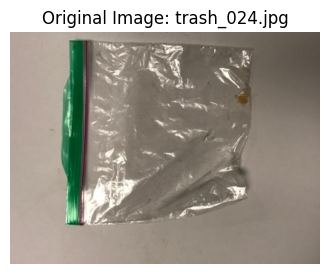

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


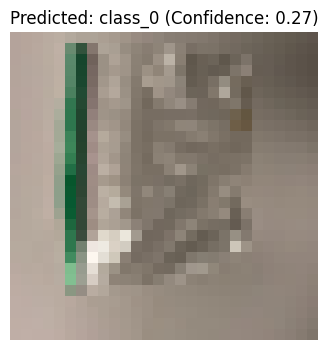

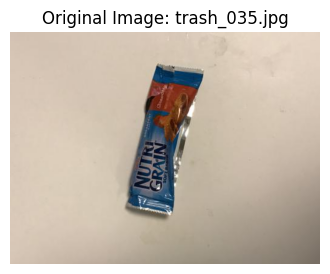

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


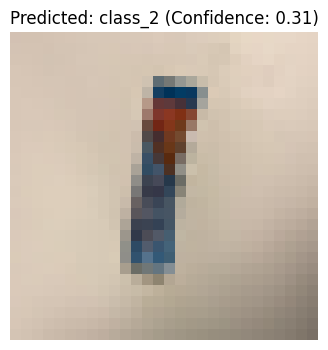

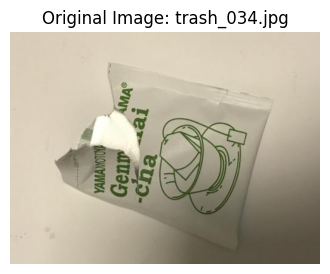

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


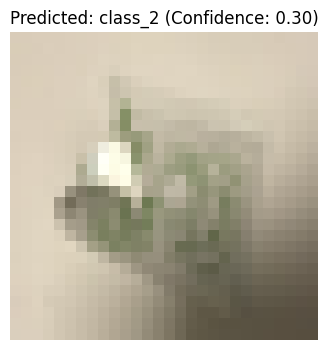

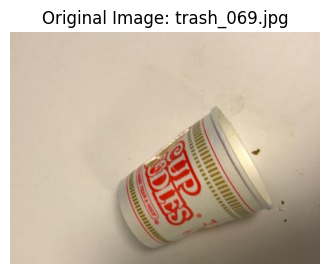

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


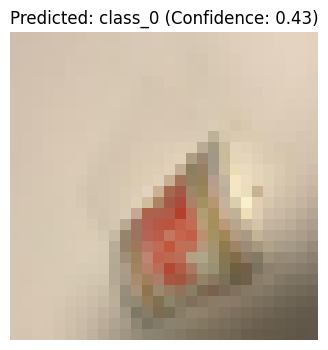

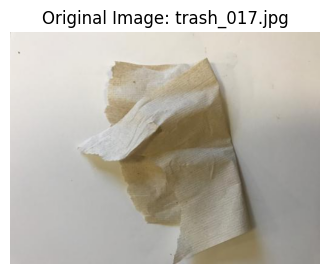

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


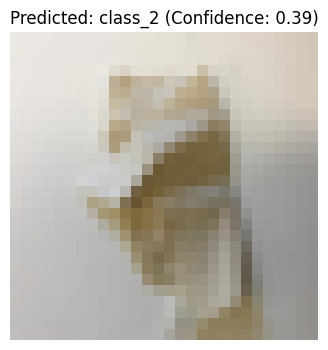

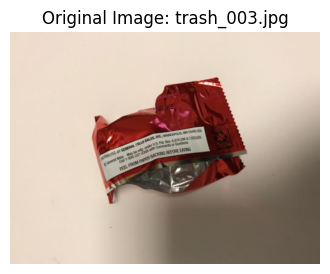

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


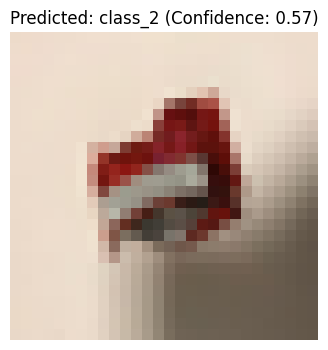

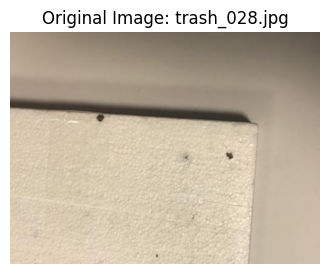

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


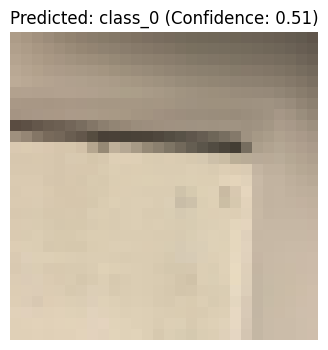

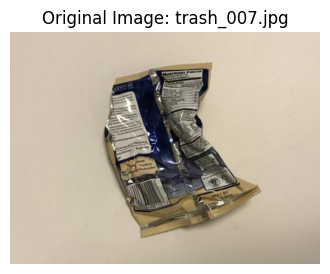

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


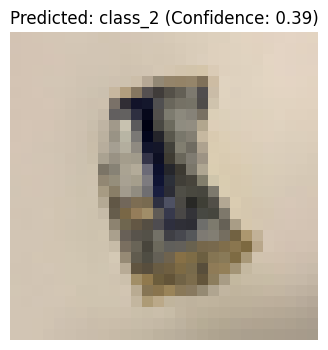

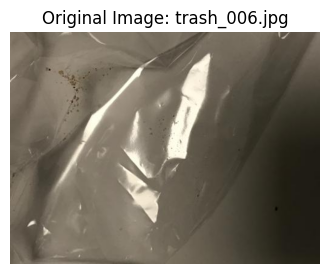

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


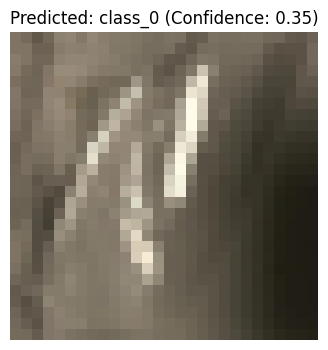

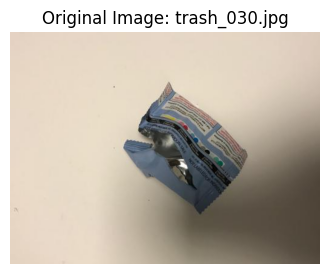

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


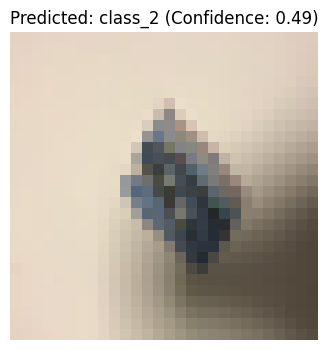

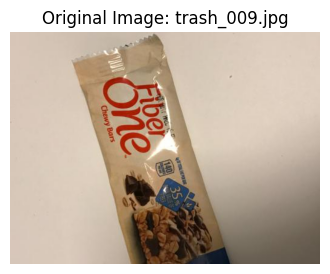

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


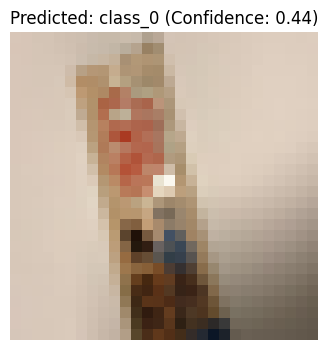

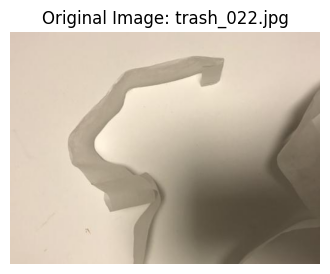

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


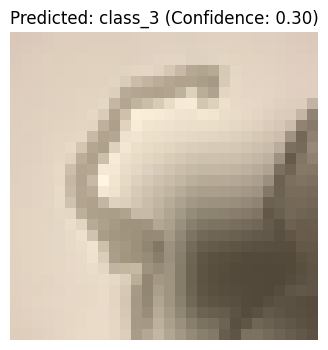

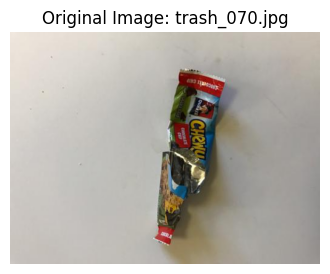

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


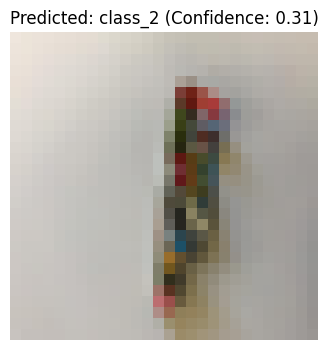

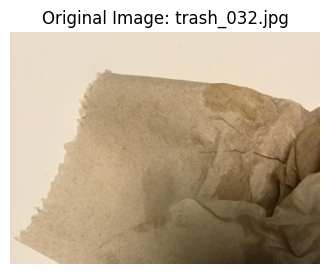

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


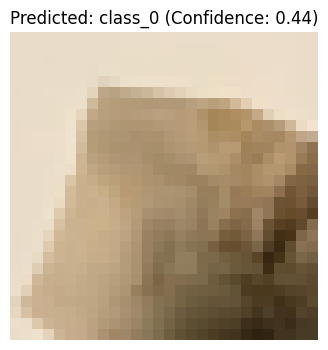

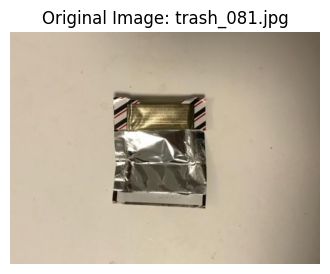

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


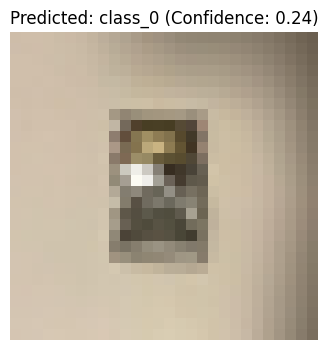

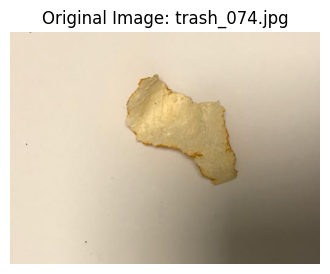

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


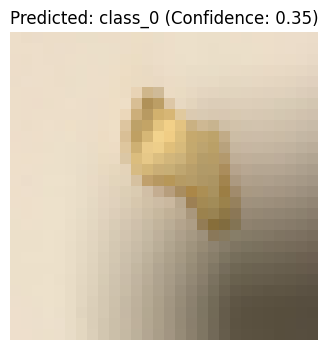

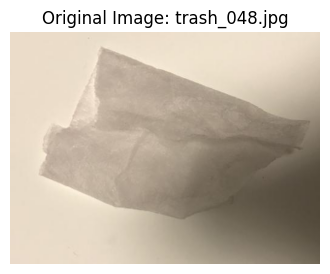

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


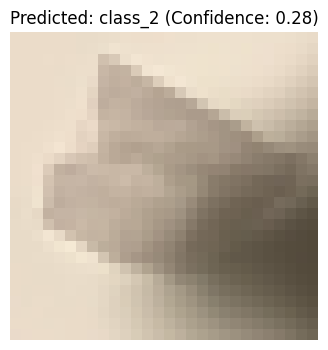

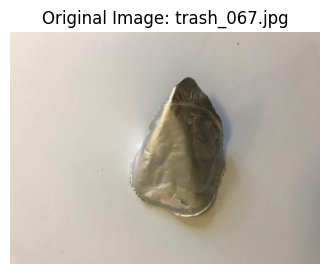

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


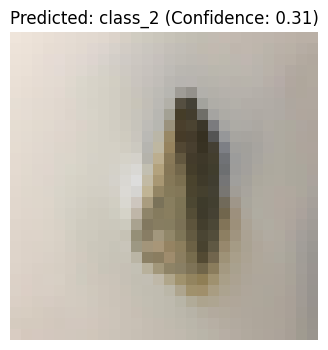

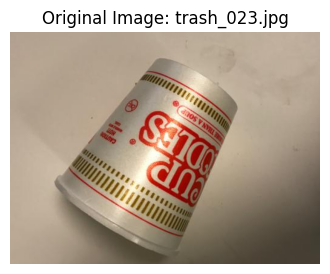

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


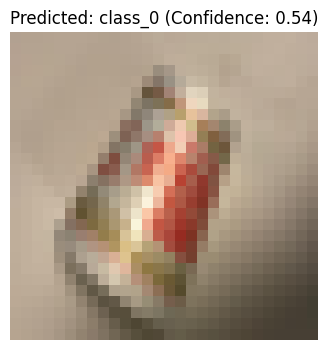

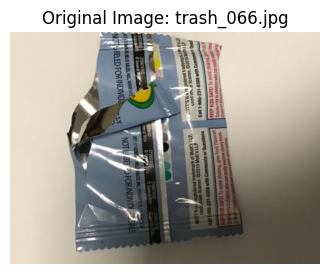

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


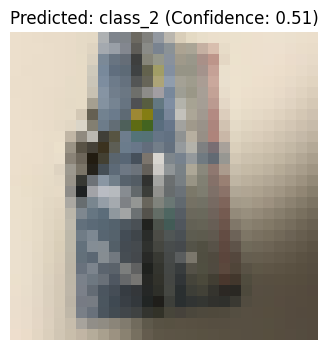

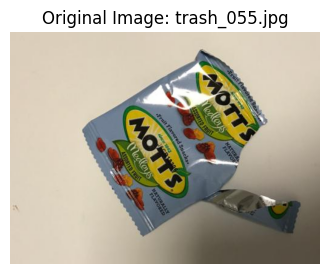

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


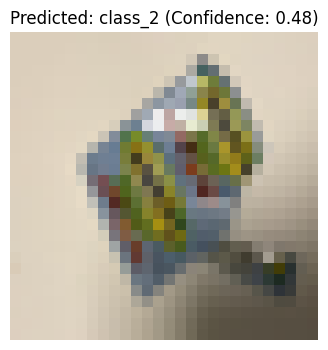

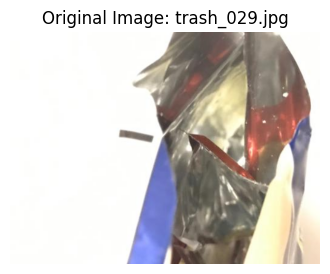

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


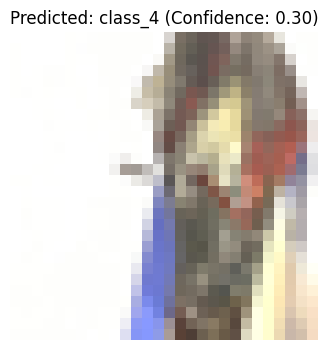

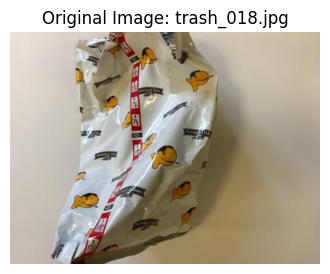

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


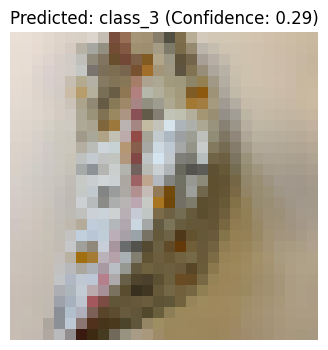

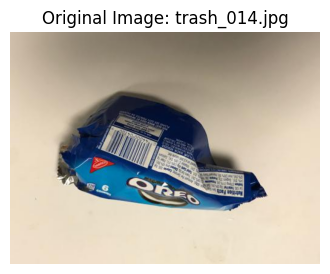

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


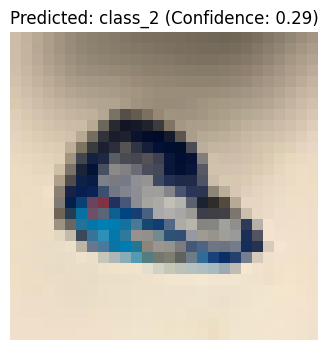

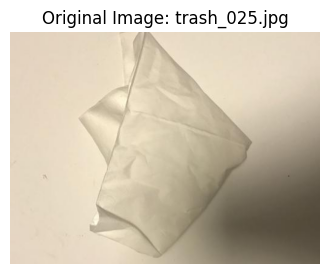

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


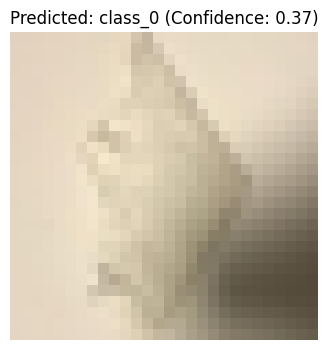

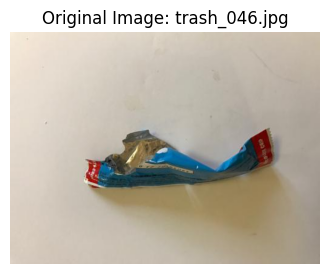

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


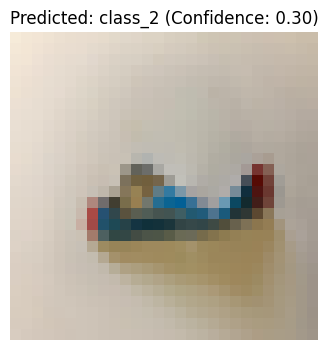

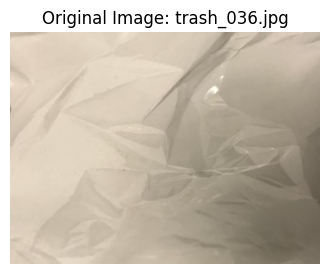

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


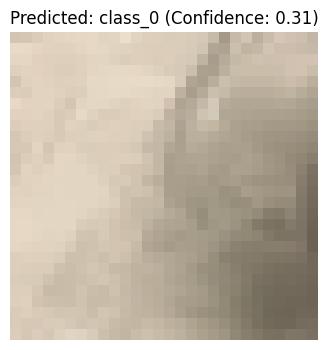

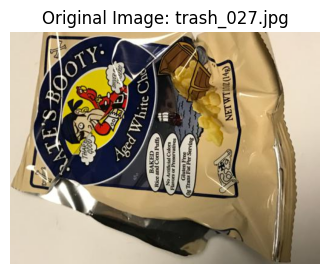

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


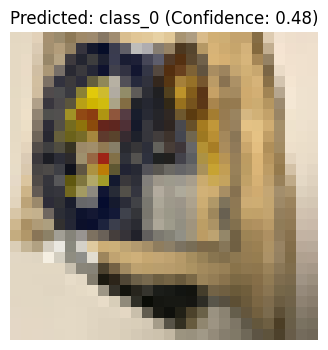

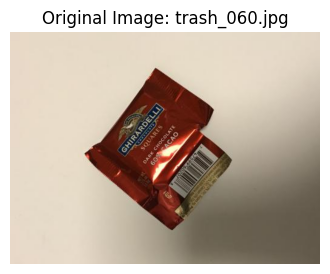

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


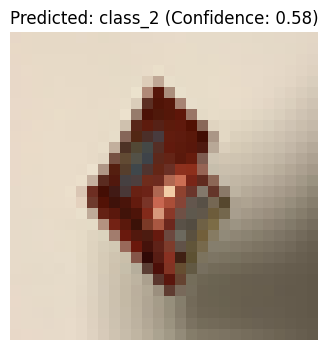

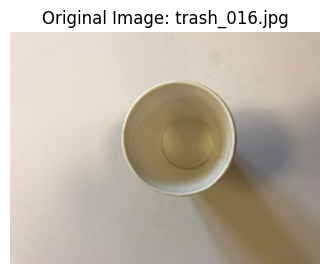

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


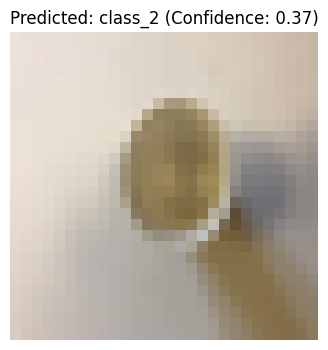

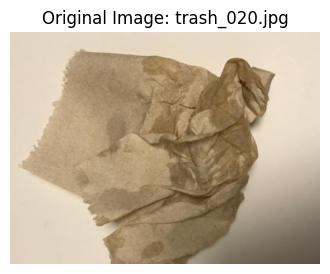

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


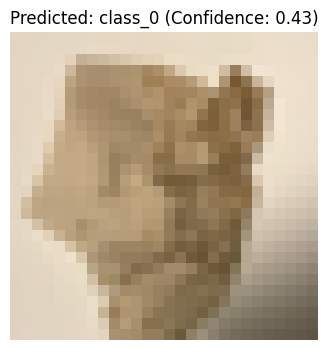

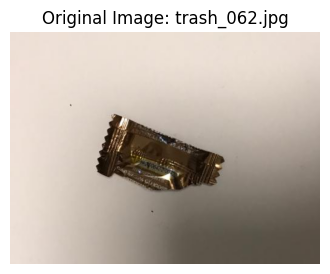

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


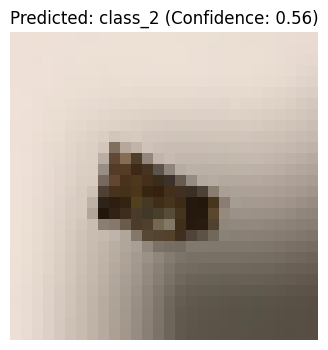

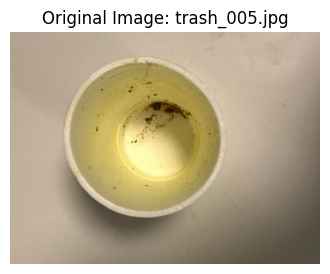

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


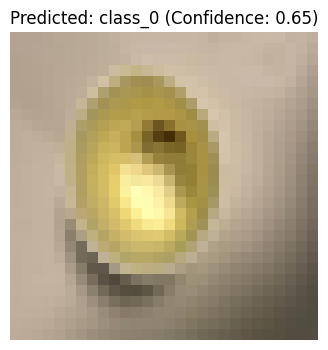

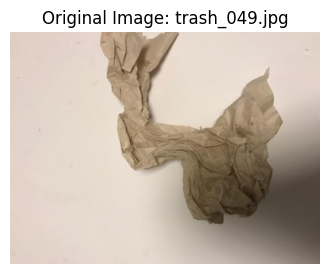

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


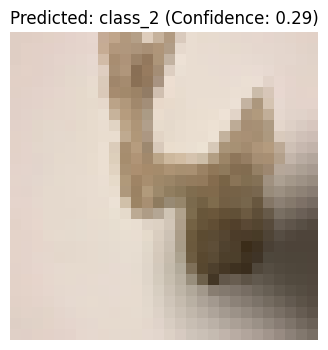

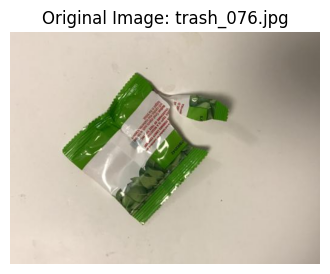

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


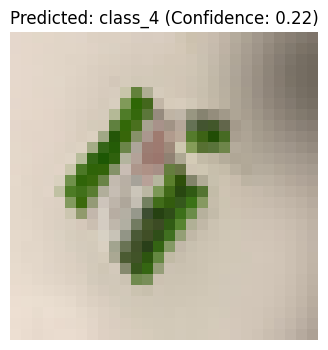

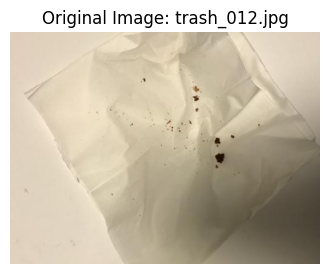

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


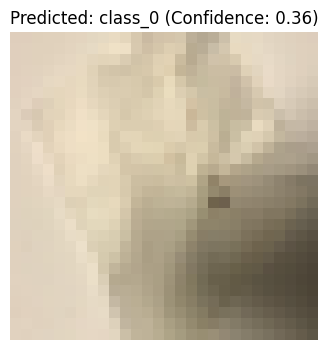

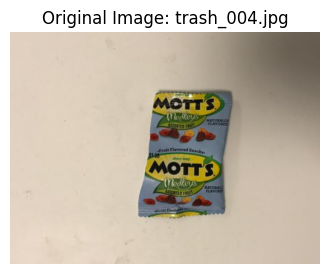

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


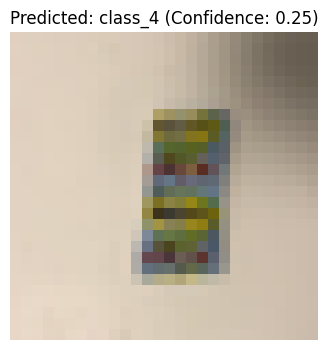

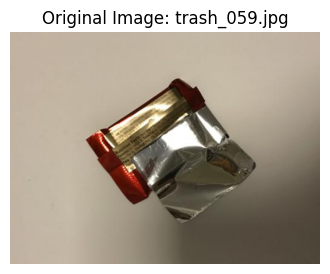

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


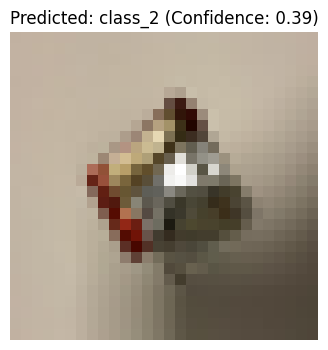

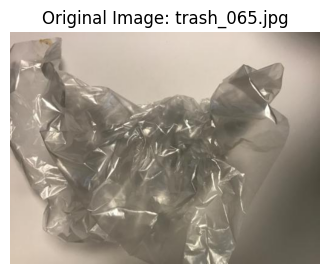

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


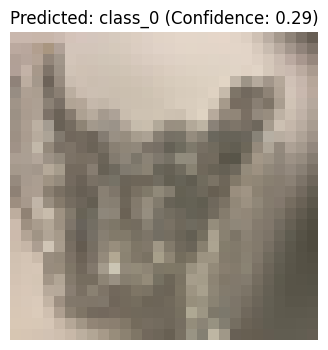

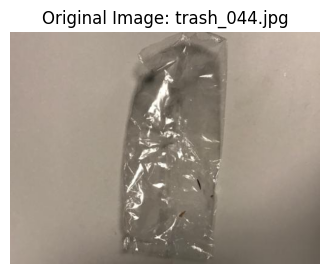

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


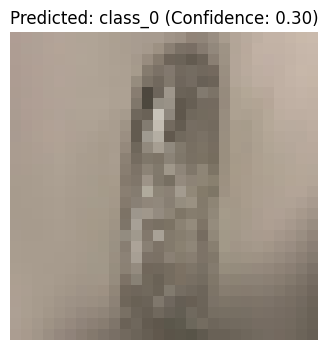

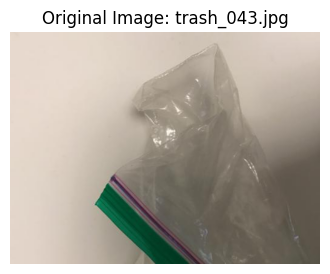

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


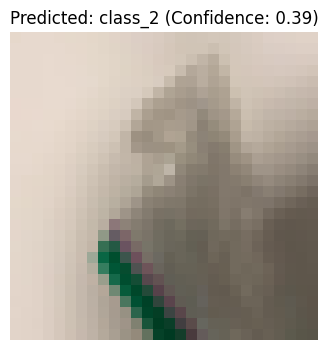

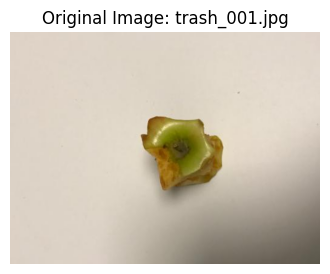

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


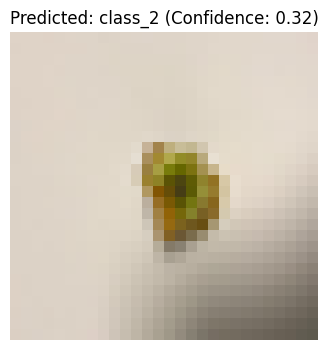

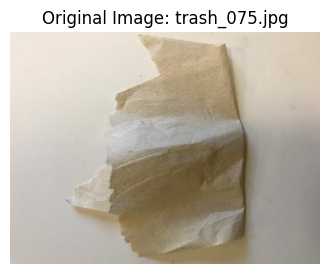

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


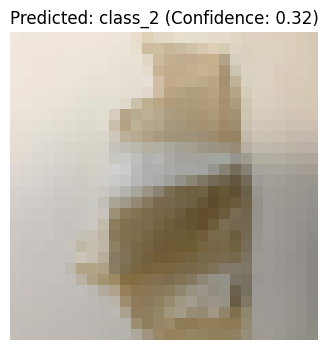

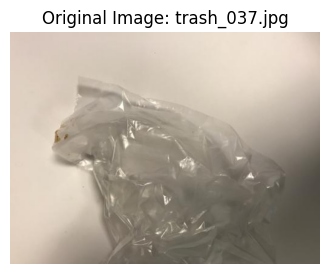

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


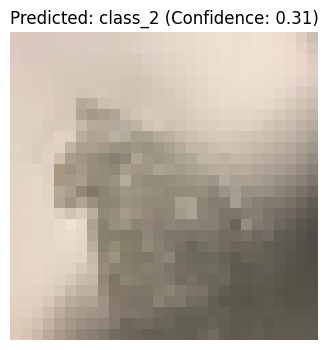

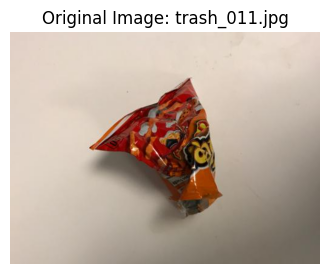

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


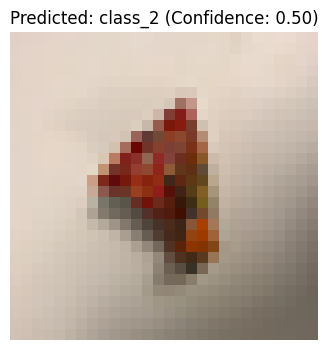

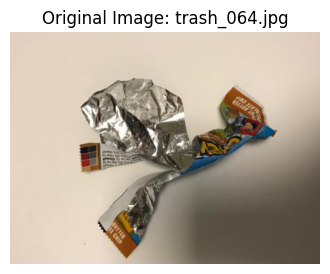

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


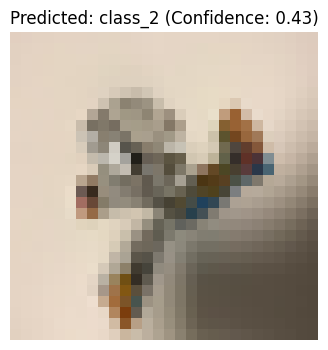

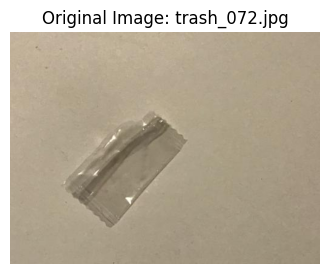

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


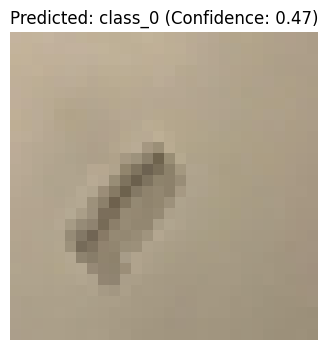

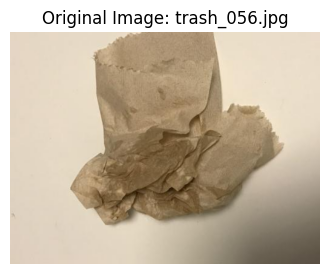

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


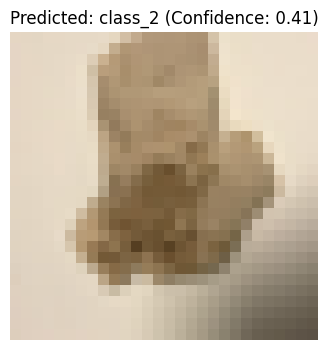

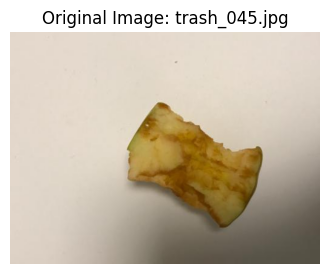

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


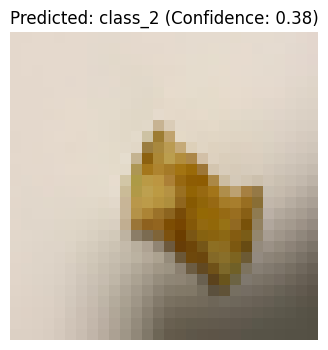

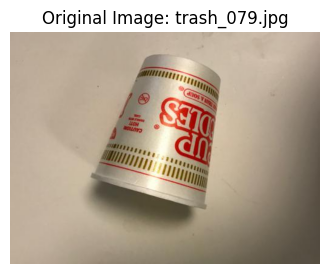

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


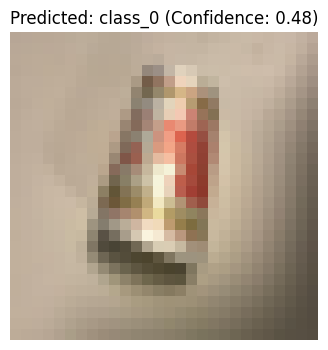

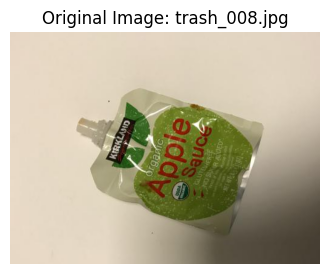

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

In [ ]:
# 'trash' 폴더 경로 지정
trash_folder_path = '/content/drive/MyDrive/my_dataset/trash'

# 'trash' 폴더가 존재하는지 확인
if not os.path.exists(trash_folder_path):
    print(f"'{trash_folder_path}' 폴더를 찾을 수 없습니다. 폴더 경로를 확인해주세요.")
else:
    # 'trash' 폴더 안의 이미지 파일 목록 가져오기
    trash_image_files = glob.glob(os.path.join(trash_folder_path, '*.jpg')) # .jpg 파일만 가정, 필요에 따라 확장자 추가

    if len(trash_image_files) == 0:
        print(f"'{trash_folder_path}' 폴더에 .jpg 이미지 파일이 없습니다.")
    else:
        print(f"'{trash_folder_path}' 폴더에서 {len(trash_image_files)}개의 이미지 파일을 찾았습니다.")

        # 클래스 이름 (라벨) 매핑 확인
        # 이전 셀에서 정의된 class_names를 사용합니다.
        if 'class_names' not in globals():
            print("경고: 'class_names' 변수가 정의되지 않았습니다. 이전 셀을 실행했는지 확인해주세요.")
            # 대체 또는 오류 처리 로직 추가 가능
            class_names = [f'class_{i}' for i in range(model.output_shape[-1])] # 모델 출력 레이어 크기로 클래스 수 추정 (예: 5)


        # 각 이미지에 대해 분류 및 표시
        for img_path in trash_image_files:
            try:
                # 이미지 로드
                img_original = Image.open(img_path).convert('RGB')

                # 원본 이미지 표시
                plt.figure(figsize=(4, 4)) # 원본 이미지 크기에 맞춰 조절 가능
                plt.imshow(img_original)
                plt.title(f"Original Image: {os.path.basename(img_path)}")
                plt.axis('off')
                plt.show()


                # 이미지 전처리 (모델 입력에 맞게 리사이즈 및 정규화)
                img_resized = img_original.resize((28, 28)) # 원하는 크기로 리사이즈
                img_array = np.array(img_resized) / 255.0 # 정규화
                img_array = np.expand_dims(img_array, axis=0) # 모델 입력 형태에 맞게 차원 추가 (batch_size=1)

                # 모델 예측
                predictions = model.predict(img_array)
                predicted_class_index = np.argmax(predictions[0])
                predicted_class_name = class_names[predicted_class_index]
                confidence = np.max(predictions[0])

                # 예측 결과 표시 (리사이즈된 이미지와 함께 표시)
                plt.figure(figsize=(4, 4)) # 예측 결과 이미지 크기에 맞춰 조절 가능
                plt.imshow(img_resized)
                plt.title(f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})")
                plt.axis('off')
                plt.show()

            except Exception as e:
                print(f"'{img_path}' 처리 중 오류 발생: {e}")

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

def classify_single_image(image_path, model, class_names):
    """
    주어진 이미지 파일 경로의 이미지를 분류하고 결과를 표시하는 함수 (Dense 모델 사용)

    Args:
        image_path (str): 분류할 이미지 파일의 전체 경로
        model (keras.Model): 훈련된 Keras 모델 (Dense 모델)
        class_names (list): 클래스 이름 목록 (라벨 매핑)
    """
    if not os.path.exists(image_path):
        print(f"'{image_path}' 파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")
        return

    try:
        # 이미지 로드
        img_original = Image.open(image_path).convert('RGB')

        # 원본 이미지 표시
        plt.figure(figsize=(6, 6))
        plt.imshow(img_original)
        plt.title(f"Original Image: {os.path.basename(image_path)}")
        plt.axis('off')
        plt.show()

        # 이미지 전처리 (모델 입력에 맞게 리사이즈 및 정규화)
        img_resized = img_original.resize((28, 28))
        img_array = np.array(img_resized) / 255.0
        img_array = np.expand_dims(img_array, axis=0) # 모델 입력 형태에 맞게 차원 추가 (batch_size=1)

        # 모델 예측
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions[0])
        predicted_class_name = class_names[predicted_class_index]
        confidence = np.max(predictions[0])

        # 예측 결과 출력
        print(f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})")

    except Exception as e:
        print(f"'{image_path}' 처리 중 오류 발생: {e}")

# 사용 예시:
# 분류하고자 하는 이미지 파일의 전체 경로를 아래 image_file_path 변수에 입력하세요.
# 예: '/content/drive/MyDrive/my_dataset/trash/image1.jpg'

image_file_path = '/content/drive/MyDrive/my_dataset/trash/trash_002.jpg'
classify_single_image(image_file_path, model, class_names)

# 아래는 예시 코드이므로 실행하려면 image_file_path 변수를 실제 파일 경로로 수정하고 주석을 해제하세요.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# CNN 모델 정의
cnn_model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax') # 출력층 (클래스 수: 5)
])

In [ ]:
# CNN 모델 컴파일
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
# CNN 모델 훈련
history_cnn = cnn_model.fit(train_input, train_target, epochs=10, validation_data=(val_input, val_target))

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

def classify_single_image_cnn(image_path, model, class_names):
    """
    주어진 이미지 파일 경로의 이미지를 분류하고 결과를 표시하는 함수 (CNN 모델 사용)

    Args:
        image_path (str): 분류할 이미지 파일의 전체 경로
        model (keras.Model): 훈련된 Keras 모델 (CNN 모델)
        class_names (list): 클래스 이름 목록 (라벨 매핑)
    """
    if not os.path.exists(image_path):
        print(f"'{image_path}' 파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")
        return

    try:
        # 이미지 로드
        img_original = Image.open(image_path).convert('RGB')

        # 원본 이미지 표시
        plt.figure(figsize=(6, 6))
        plt.imshow(img_original)
        plt.title(f"Original Image: {os.path.basename(image_path)}")
        plt.axis('off')
        plt.show()

        # 이미지 전처리 (모델 입력에 맞게 리사이즈 및 정규화)
        img_resized = img_original.resize((28, 28))
        img_array = np.array(img_resized) / 255.0
        img_array = np.expand_dims(img_array, axis=0) # 모델 입력 형태에 맞게 차원 추가 (batch_size=1)

        # 모델 예측
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions[0])
        predicted_class_name = class_names[predicted_class_index]
        confidence = np.max(predictions[0])

        # 예측 결과 표시 (리사이즈된 이미지와 함께 표시)
        plt.figure(figsize=(4, 4)) # 예측 결과 이미지 크기에 맞춰 조절 가능
        plt.imshow(img_resized)
        plt.title(f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})")
        plt.axis('off')
        plt.show()

        # 디버깅 print 추가
        print(f"Predictions: {predictions}")
        print(f"Predicted class index: {predicted_class_index}")
        print(f"Predicted class name: {predicted_class_name}")
        print(f"Confidence: {confidence}")


        # 예측 결과 출력 (프린트도 유지)
        print(f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})")


    except Exception as e:
        print(f"'{image_path}' 처리 중 오류 발생: {e}")

# 사용 예시:
# 분류하고자 하는 이미지 파일의 전체 경로를 아래 image_file_path 변수에 입력하세요.
# 예: '/content/drive/MyDrive/my_dataset/trash/image1.jpg'

image_file_path = '/content/drive/MyDrive/my_dataset/trash/trash_004.jpg'
classify_single_image_cnn(image_file_path, cnn_model, class_names)

# 아래는 예시 코드이므로 실행하려면 image_file_path 변수를 실제 파일 경로로 수정하고 주석을 해제하세요.